In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime
import math
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('start reading...')
prefix = "/Users/isabelniu/Documents/HKUST-20Spring/ML/Project/CompleteDataSet/"
train = pd.read_csv(prefix + "FinalEncodedTrain.csv")
test = pd.read_csv(prefix + "FinalEncodedTest.csv")
print('done reading')

start reading...
done reading


In [4]:
train=train.drop(train.columns[0],1)
test=test.drop(test.columns[0],1)

In [5]:
print('data split start...')
# Features and target varaibles
X = train.drop(columns='target',axis=1)
Y = train['target']

data split start...


In [6]:
del train

In [7]:
# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(X, Y, test_size=0.2)

# Further split train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2)
print('data split done.')

data split done.


In [8]:
del X
del Y
del X_train_all
del y_train_all
import gc
gc.collect()

37

In [9]:
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]

In [10]:
# Sampled data
idx = random.sample(range(0,X_train.shape[0]), 500000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [11]:
small_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3,
                                         verbose=0,
                                         max_depth= 2)

small_model.fit(X_train, y_train)

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, eval_metric='binary_logloss',
               importance_type='split', learning_rate=0.3, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=0)

In [12]:
#Fitting a model on sampled data
sk_reg = lgb.sklearn.LGBMClassifier(
         objective='binary',
         eval_metric='binary_logloss',
         boosting='gbdt',
         learning_rate=0.3 ,
         verbose=0,
         num_leaves=600,
         bagging_freq= 1,
         feature_fraction= 0.9,
         max_bin= 256,
         max_depth= 300,
         num_rounds= 200,
)


sk_reg.fit(X_train_sampled, y_train_sampled)

LGBMClassifier(bagging_freq=1, boosting='gbdt', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0,
               eval_metric='binary_logloss', feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_bin=256,
               max_depth=300, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=600,
               num_rounds=200, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [13]:
predicted = sk_reg.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.669


                   cols    imp
21                 msno  12279
20      membership_days   9614
27              song_id   8272
29          song_length   7910
9     count_song_played   7857
23    registration_date   7534
10      expiration_date   7329
8   count_artist_played   6866
3           artist_name   6838
6              composer   5204


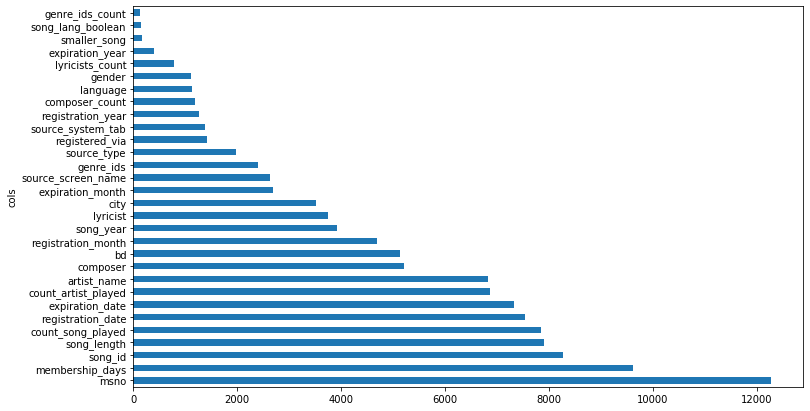

In [14]:
#determine the importance of features
def lgb_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = lgb_feat_importance(sk_reg, X_train_sampled ); 
print(fi[:10])

def plot_fi(fi):return fi.plot('cols', 'imp', 'barh',
                               figsize=(12,7), legend=False)
plot_fi(fi[:30])
plt.show()

In [16]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', lgb.sklearn.LGBMClassifier())]) # Estimator: ML algorithm

grid_params = dict(
         clf__objective=['binary'],
         clf__eval_metric=['binary_logloss'],
         clf__boosting_type=['gbdt'],
         clf__learning_rate=[0.3] ,
         clf__verbose=[0],
         clf__num_leaves=[300, 350, 250],
         clf__feature_fraction= [0.9],
         clf__max_bin= [256],
         clf__max_depth= [200, 150, 250],
         clf__num_rounds= [200])
gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

'0.6705'

In [17]:
# Best algorithm with best hyperparameters 
# (need to fit it to find specific model parameters)
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
         steps=[('clf',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0,
                                eval_metric='binary_logloss',
                                feature_fraction=0.9, importance_type='split',
                                learning_rate=0.3, max_bin=256, max_depth=200,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=250, num_rounds=200,
                                objective='binary', random_state=None,
                                reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000,
                                subsample_freq=0, verbose=0))],
         verbose=False)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='binary_logloss', feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_bin=256,
               max_depth=200, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=250,
               num_rounds=200, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [18]:
#Fitting the best model on all the data
Final_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3 ,
                                         verbose=0,
                                         num_leaves=250,
                                         bagging_freq= 1,
                                         feature_fraction= 0.9,
                                         max_bin= 256,
                                         max_depth= 200,
                                         num_rounds= 200)

In [19]:
#Validation accuracy
Final_model.fit(X_train, y_train)
predicted = Final_model.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation: {accuracy:.3}')

Mean accuracy score on validation: 0.711


In [20]:
# Test accuracy
predicted = Final_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.712


In [21]:
#evaluation matrix

In [22]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.71644781 0.70699461]
recall: [0.69424045 0.72863771]
fscore: [0.70516933 0.71765301]
support: [733148 742336]


Confusion matrix, without normalization
[[508981 224167]
 [201442 540894]]
Normalized confusion matrix
[[0.69 0.31]
 [0.27 0.73]]


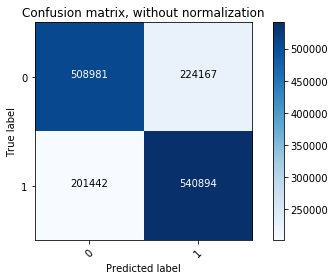

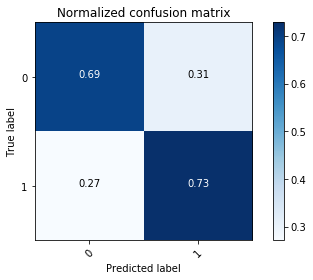

In [23]:
#plot confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [24]:
# Predict probability for ROC curve
predicted = Final_model.predict_proba(X_test)

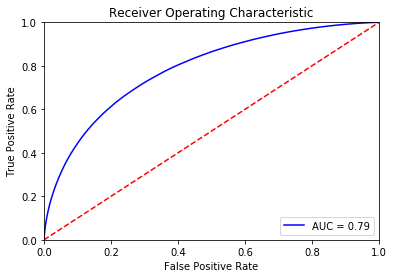

In [25]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1]for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate,
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
test.shape

(2556790, 34)

In [72]:
test.columns

Index(['artist_composer', 'artist_composer_lyricist', 'artist_count',
       'artist_name', 'bd', 'city', 'composer', 'composer_count',
       'count_artist_played', 'count_song_played', 'expiration_date',
       'expiration_month', 'expiration_year', 'gender', 'genre_ids',
       'genre_ids_count', 'is_featured', 'language', 'lyricist',
       'lyricists_count', 'membership_days', 'msno', 'registered_via',
       'registration_date', 'registration_month', 'registration_year',
       'smaller_song', 'song_id', 'song_lang_boolean', 'song_length',
       'song_year', 'source_screen_name', 'source_system_tab', 'source_type'],
      dtype='object')

In [42]:
predicted = Final_model.predict_proba(test)

In [ ]:
test=test.drop(['id'],1)

In [43]:
submission=pd.read_csv(prefix+'CompleteDataSet/sample_submission.csv')
submission.target= predicted
submission.to_csv('Result/LGBM_smallSet.csv',index=False)

In [48]:
train = pd.read_csv(prefix + "FinalEncodedTrain.csv")
Y=train.target
train=train.drop(train.columns[0],1)

In [67]:
print(train.shape,Y.shape,test.shape)

(7377418, 34) (7377418,) (2556790, 35)


In [50]:
train=train.drop('target',1)

In [61]:
Final_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.1 ,
                                         verbose=0,
                                         num_leaves=250,
                                         bagging_freq= 1,
                                         feature_fraction= 0.9,
                                         max_bin= 256,
                                         max_depth= 200,
                                         num_rounds= 200)

In [62]:
Final_model.fit(train, Y)

LGBMClassifier(bagging_freq=1, boosting='gbdt', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0,
               eval_metric='binary_logloss', feature_fraction=0.9,
               importance_type='split', learning_rate=0.1, max_bin=256,
               max_depth=200, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=250,
               num_rounds=200, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [74]:
predicted = Final_model.predict(test)

In [75]:
submission.target= predicted
submission.to_csv('Result/LGBM_LargeSet2.csv',index=False)